# Housing Price Regression - Kaggle Competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

### Using Sklearn's Random Forest for ML vs Fastai/Pytorch Neural Net for DL to compare results, matplotlib for visualizations

In [4]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# import data

In [5]:
df = pd.read_csv('housing_train.csv')

# explore data a bit

In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# dependent variable

In [7]:
dep_var = 'SalePrice'

In [8]:
#results evaluated on RMSE between log of predicted and actual sales price
df[dep_var] = np.log(df[dep_var])

# TabularProc (categorify, fillmissing), Tabular Pandas(splits df)

### TabularProc and TabularPandas are modules in the fastai package that performs tasks depending on one's input. 
### Here, I'm using Category and FillMissing for TabularProc which will turn all values into categorical objects, and fill any null values with that column's median by default. It will also create an additional column containing a boolean whether or not there is a value given for the given column.
### I am also using TabularPandas to split the given dataset into a train and validation set as well as create a Y value - in this case, it is what we defined SalePrice as above, dep_var.

In [9]:
procs = [Categorify,FillMissing]

In [10]:
# Because we are dealing with time series data, we must create our validation set with the most recent data. In this case, 
# The validation set thus contains the last 6 months of data.
cond = (df.YrSold <2010) | (df.MoSold < 5)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

In [11]:
cont,cat = cont_cat_split(df,1,dep_var=dep_var)

In [12]:
to = TabularPandas(df, procs,cat,cont,y_names = dep_var,splits = splits)

In [13]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

# Basic Decision Tree Regression to visualize what's going on and to get baseline prediction

In [31]:
m = DecisionTreeRegressor(max_leaf_nodes = 5)
m.fit(xs,y)

DecisionTreeRegressor(max_leaf_nodes=5)

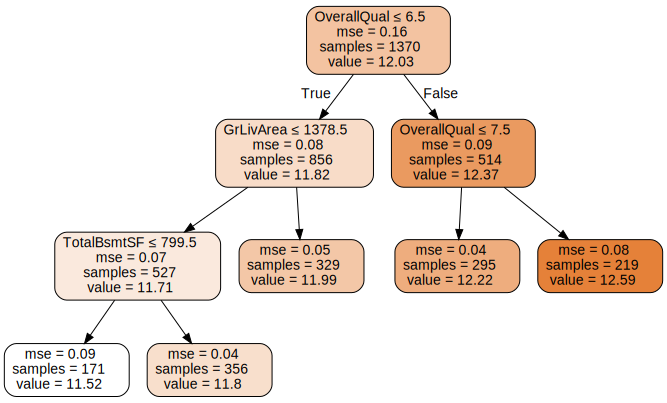

In [32]:
draw_tree(m,xs,precision = 2)

In [33]:
to.train.show(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,#na#,Attchd,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,12.247694
1,RL,Pave,#na#,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,12.109011
2,RL,Pave,#na#,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,12.317166


In [34]:
to.items.shape, to.train.items.shape, to.valid.items.shape

((1460, 84), (1370, 84), (90, 84))

In [ ]:
#Create a RMSE calculator for convenience.

In [35]:
def rmse (pred,y):
    return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m,xs,y): return rmse(m.predict(xs),y)

In [36]:
m_rmse(m,xs,y)

0.233257

In [37]:
m_rmse(m,valid_xs,valid_y)

0.236643

# RANDOM FOREST

In [39]:
def rf(xs,y,n_estimators = 40, max_features = 0.5, min_samples_leaf =4, **kwargs):
    return RandomForestRegressor(n_jobs = -1, max_features = max_features, n_estimators = n_estimators,
                                min_samples_leaf = min_samples_leaf, oob_score = True).fit(xs,y)

In [40]:
m = rf(xs,y);

In [41]:
#Training rmse vs validation rmse.

m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.088709, 0.141448)

In [42]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [43]:
rmse(preds.mean(0), valid_y)

0.141448

In [ ]:
# Visual to see how RMSE changes when we change how many trees are used in our model. 

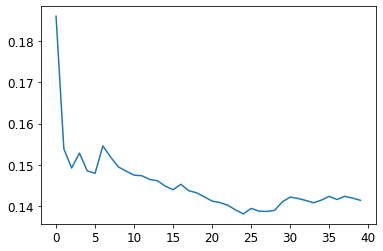

In [44]:
plt.plot([rmse(preds[:i+1].mean(0),valid_y) for i in range(40)]);

# oob_score 
#### .. Easy and rather accurate evaluation using Random Forest's "Out of bag" score

In [46]:
rmse(m.oob_prediction_, y)

0.146105

# Tree variance for prediction confidence

#### How confident are we for a given house Sale Price prediction?

In [50]:
preds_std = preds.std(0)

In [55]:
# The Lower standard deviation, the more confident we are for a given prediction. 
preds_std[:10]

array([0.12224605, 0.11730642, 0.11145255, 0.16818207, 0.15646092, 0.16897092, 0.08675185, 0.22301034, 0.2236496 , 0.1200794 ])

# Feature importance
###  .. Defining which variables contribute the most to model's preditctions

In [52]:
def feat_imp(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}
                       ).sort_values('imp',ascending = False)

In [53]:
fi = feat_imp(m,xs)
fi[:20]

,cols,imp
50,OverallQual,0.314047
62,GrLivArea,0.170347
52,YearBuilt,0.100643
72,GarageCars,0.052393
18,ExterQual,0.045295
58,TotalBsmtSF,0.037074
59,1stFlrSF,0.036100
73,GarageArea,0.030687
30,KitchenQual,0.021983
55,BsmtFinSF1,0.019870


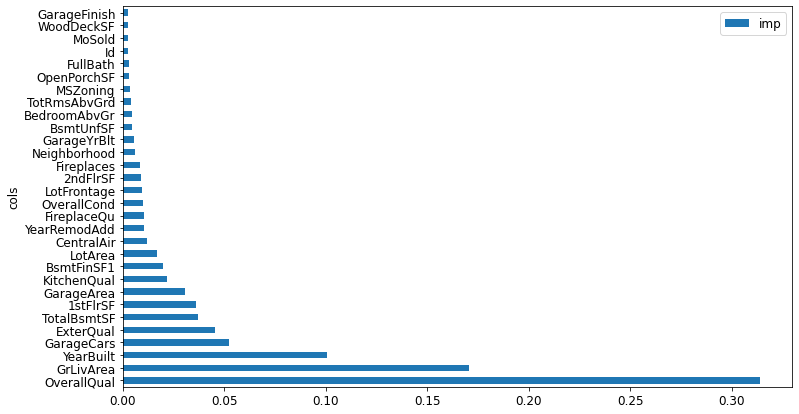

In [54]:
def plot_fi(fi):
    return fi.plot('cols','imp','barh',figsize = (12,7))
plot_fi(fi[:30]);

# Removing low-importance variables
## This simplifies the model and will help it generalize better.

In [56]:
to_keep = fi[fi.imp > 0.005].cols
to_keep.shape

(20,)

In [57]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [58]:
xs_imp.shape, valid_xs_imp.shape

((1370, 20), (90, 20))

In [59]:
m = rf(xs_imp,y)

In [60]:
m_rmse(m,xs_imp,y), m_rmse(m,valid_xs_imp,valid_y)

(0.091523, 0.143751)

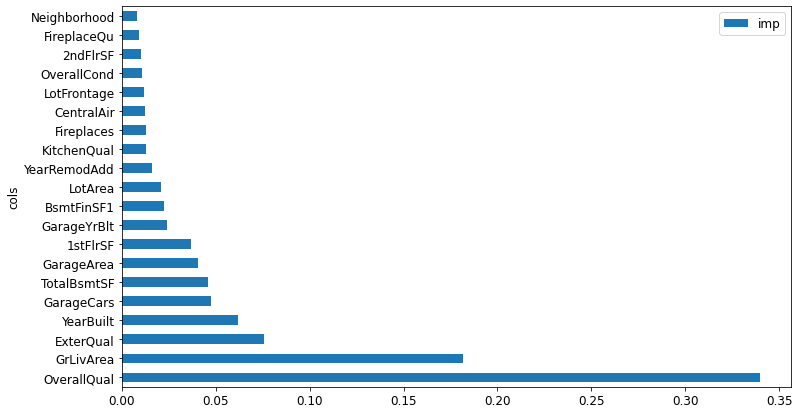

In [61]:
plot_fi(feat_imp(m,xs_imp));

# Removing redundant features

#### This visual aid helps us see which features are redundant by testing for correlations and displaying it on a tree. If the segments on the right side of the graph are very close to each other, we should test the performance of the model with removing each of the 'redundant' features.  In this case, 'Fireplaces' and 'FireplaceQu' are closest together, but there still seems to be variance between the two. There are seemingly no redundant features to remove/test for.

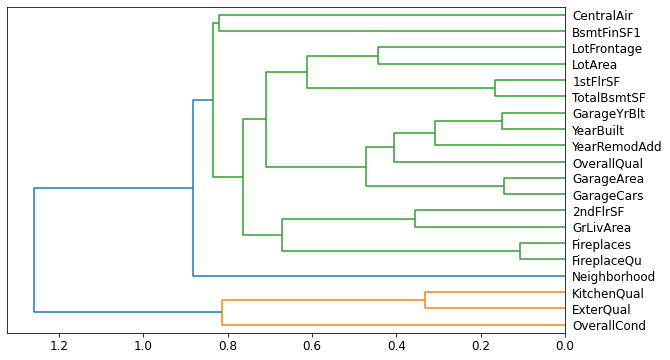

In [64]:
cluster_columns(xs_imp)

In [ ]:
#none 

# Out of domain data

#### Do we have any 'out of domain' data that is PREDICTABLY within the validation dataset, and thus, skewing our training model predictions?


In [75]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [76]:
m = rf(xs_final,y)
m_rmse(m,xs_final,y), m_rmse(m,valid_xs_final,valid_y)

(0.094723, 0.142848)

In [77]:
df_dom = pd.concat([xs_final,valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [78]:
m = rf(df_dom,is_valid)
boop = feat_imp(m,df_dom)

In [79]:
boop_imp = boop[boop.imp < 0.01]

In [80]:
m = rf(xs_final,y)
print('orig', m_rmse(m,valid_xs_final,valid_y))
for c in (boop_imp.cols):
    m = rf(xs_final.drop(c,axis = 1), y)
    print (c, m_rmse(m,valid_xs_final.drop(c,axis = 1), valid_y))


orig 0.141797
KitchenQual 0.141242
GarageCars 0.141103
CentralAir 0.148329


# Neural network

In [81]:
df_nn = pd.read_csv('housing_train.csv', low_memory = False)
df_nn[dep_var] = np.log(df_nn[dep_var])

In [82]:
df_nn_final = df_nn[list(xs_final.columns) + [dep_var]]

In [83]:
df_nn_final.shape

(1460, 21)

In [84]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card = 150,dep_var = dep_var)

In [85]:
df_nn_final[cat_nn].nunique()

OverallQual      10
YearBuilt       112
GarageCars        5
ExterQual         4
KitchenQual       4
CentralAir        2
YearRemodAdd     61
FireplaceQu       5
OverallCond       9
Fireplaces        4
Neighborhood     25
dtype: int64

In [86]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final,procs_nn,cat_nn,cont_nn,splits = splits, y_names=dep_var)

In [87]:
dls = to_nn.dataloaders(128)

In [88]:
y = to_nn.train.y
y.min(),y.max()

(10.460242, 13.534473)

In [89]:
learn = tabular_learner(dls,y_range = (10,14),n_out =1,loss_func = F.mse_loss)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.3182567358016968)

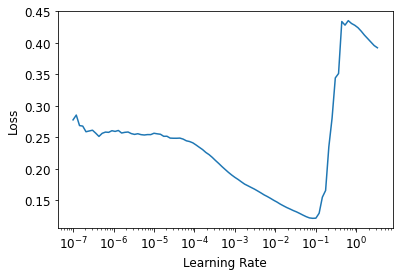

In [90]:
learn.lr_find()

In [95]:
learn.fit_one_cycle(20,2e-4)

epoch,train_loss,valid_loss,time
0,0.003199,0.022982,00:00
1,0.003649,0.022991,00:00
2,0.003538,0.023358,00:00
3,0.003348,0.024035,00:00
4,0.003669,0.023411,00:00
5,0.003625,0.024086,00:00
6,0.003547,0.023447,00:00
7,0.003503,0.023869,00:00
8,0.003560,0.023848,00:00
9,0.003464,0.023830,00:00


In [96]:
preds,targs = learn.get_preds()

In [98]:
### It looks like that our Random Forest Regression is outperforming out Neural Net. This isn't terribly surprising 
# considering deep learning/neural nets is optimized for other complex tasks such as NLP or Image recognition. 
rmse(preds,targs)

0.155349